In [4]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 7.2 MB/s 
     |████████████████████████████████| 181 kB 66.4 MB/s 
     |████████████████████████████████| 144 kB 45.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6ee9d0e81fd5eff347461546a188f14356b52b1d3a485b7bcd8c6d748fe0065a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [20]:
#wandb integration
import wandb

In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

     |████████████████████████████████| 1.1 MB 7.0 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 26 kB/s 
     |████████████████████████████████| 462 kB 69.7 MB/s 


In [2]:


import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
#import tensorflow_probability as tfp

## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components. 

### Q-Network:
The neural network used as a function approximator is defined below

In [3]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()

QNetwork2: Feel free to experiment more
'''

import torch
import torch.nn as nn  
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
#BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
#BATCH_SIZE = 64         #''' minibatch size '''
#GAMMA = 0.99            #''' discount factor '''
#LR = 5e-4               #''' learning rate '''
#UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer:

This is a 'deque' that helps us store experiences. Recall why we use such a technique.

In [4]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Truncation:
We add a line (optionally) in the code to truncate the gradient in hopes that it would help with the stability of the learning process.

## Agent Code:


In [5]:
from scipy.special import softmax
import random

class Agent():

    def __init__(self, state_size, action_size, seed,\
                 method='softmax',temp=0.9,buffer_size = int(1e5),\
                batch_size = 64 ,gamma = 0.99,lr = 5e-4,update_every = 20,\
                 fc1_units=128, fc2_units=64,momentum_decay =0.9,\
                optimizer='adam'):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.method=method
        self.temp=temp
        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed,fc1_units,fc2_units).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed,fc1_units,fc2_units).to(device)
        self.optimizer =None
        if(optimizer=='adam'):
            self.optimizer=optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        if(optimizer=='nadam'):
            self.optimizer=optim.NAdam(self.qnetwork_local.parameters(), lr=lr,momentum_decay=momentum_decay)
        if(optimizer=='RMSprop'):
            self.optimizer=optim.RMSprop(self.qnetwork_local.parameters(), lr=lr)
        if(optimizer=='nesterov'):
            self.optimizer=optim.SGD(self.qnetwork_local.parameters(), lr=lr,nesterov =True,isprint=False)
        self.batch_size=batch_size
        self.gamma=gamma
        self.lr=lr
        self.update_every=update_every
        self.buffer_size=buffer_size
        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)

        ''' Initialize time step (for updating every update_every steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'update_every' steps taken '''      
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def actWithEpsilon(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    


    def actWithSoftMax(self, state,temperature):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        convertNumpy=action_values.cpu().data.numpy()
        convertNumpy=convertNumpy[0]
        if(temperature!=0):
             convertNumpy/=temperature
        sofrmX=softmax(convertNumpy)
        sofrmX/=sofrmX.sum()
        if(temperature==0):
          return np.argmax(sofrmX)
        all_possible_actions = np.arange(0, sofrmX.shape[-1])
        action = np.random.choice(all_possible_actions,p=sofrmX)
        return action
    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [6]:
''' Defining DQN Algorithm '''
def dqn(agent,n_episodes=10000, scoreThreshold=100,\
        max_t=1000, eps_start=1.0, eps_end=0.01,\
        eps_decay=0.995,method='softmax',temperature=0.9,buffer_size = int(1e5),\
        batch_size = 64 ,gamma = 0.99,LR = 5e-4,update_every = 20,wandbLog=False,isprint=True,temp_decay=0,temp_end=0.0001):

    scores = []
    steps = []    
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''
    
    eps = eps_start                    
    ''' initialize epsilon '''
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        step=0
        for t in range(max_t):
            action=None
            if(method=='epsilon'):
              action = agent.actWithEpsilon(state, eps)
            else:
              action = agent.actWithSoftMax(state, temperature)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                step=t
                break 

        scores_window.append(score)  
        steps.append(step)
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        eps = max(eps_end, eps_decay*eps) 
        #use exponential decay to reduce temperature
        if(temp_decay>0):
          temperature=max(temp_end,temp_decay*temperature  )
        ''' decrease epsilon '''
        if(isprint):
          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        if i_episode % 10 == 0: 
            scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0:
           if(wandbLog): 
              wandb.log({'reward':  np.mean(scores_window),'step': i_episode})
           if(isprint):
              print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=scoreThreshold:
          if(isprint):
              print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'\
                 .format(i_episode-100, np.mean(scores_window)))
              break
    return [np.array(scores),i_episode-100],np.array(scores_window),np.array(steps)

''' Trial run to check if algorithm runs and saves the data '''



' Trial run to check if algorithm runs and saves the data '

In [7]:
import warnings
warnings.filterwarnings("ignore")

### Acrobot-v1

In [8]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'CartPole-v0'
'MountainCar-v0'
'''

env = gym.make('Acrobot-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n
 
print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

6
3
1
----
[ 0.99603073 -0.08901003  0.99567135  0.09294385  0.02653819 -0.04199653]
----
1
----
[ 0.99743905 -0.07152157  0.99772927  0.06735206  0.14444498 -0.20745927]
-1.0
False
{}
----


### Acrobot-v1 : Sweep configuration for Epsoilon


Sweep Configuration
method: bayes
metric:
  goal: maximize
  name: reward
name: DQN
parameters:
  LR:
    values:
    - 0.01
    - 0.001
    - 0.0001
  batch_size:
    values:
    - 64
  buffer_size:
    values:
    - 100000
  eps_decay:
    values:
    - 0.1
    - 0.2
  fc1_units:
    values:
    - 64
  fc2_units:
    values:
    - 64
    - 128
  gamma:
    values:
    - 0.9
    - 0.5
  method:
    values:
    - epsilon
  n_episodes:
    values:
    - 2000
  optimizer:
    values:
    - adam

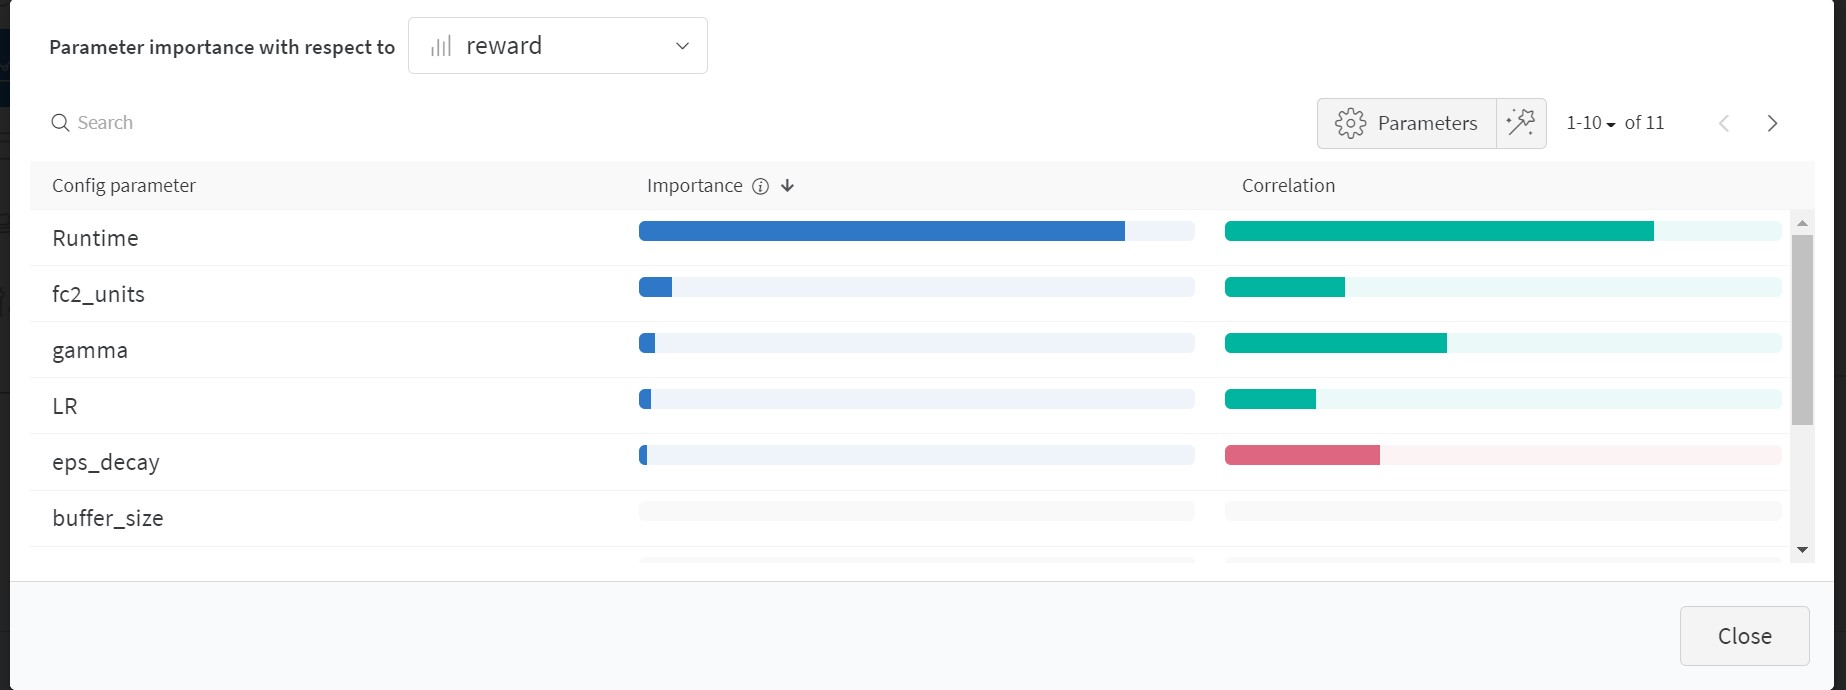

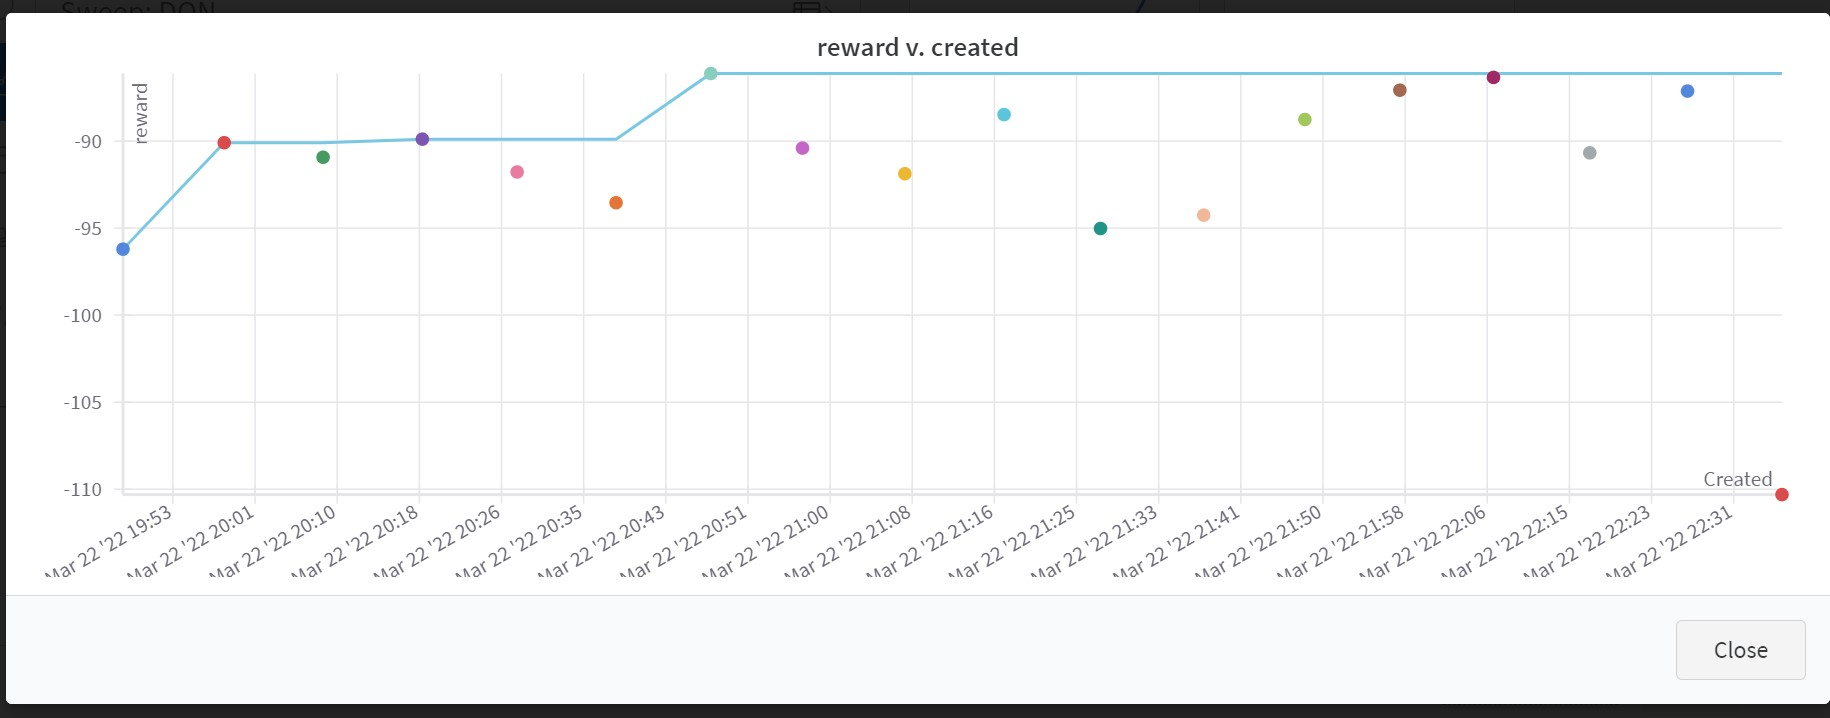

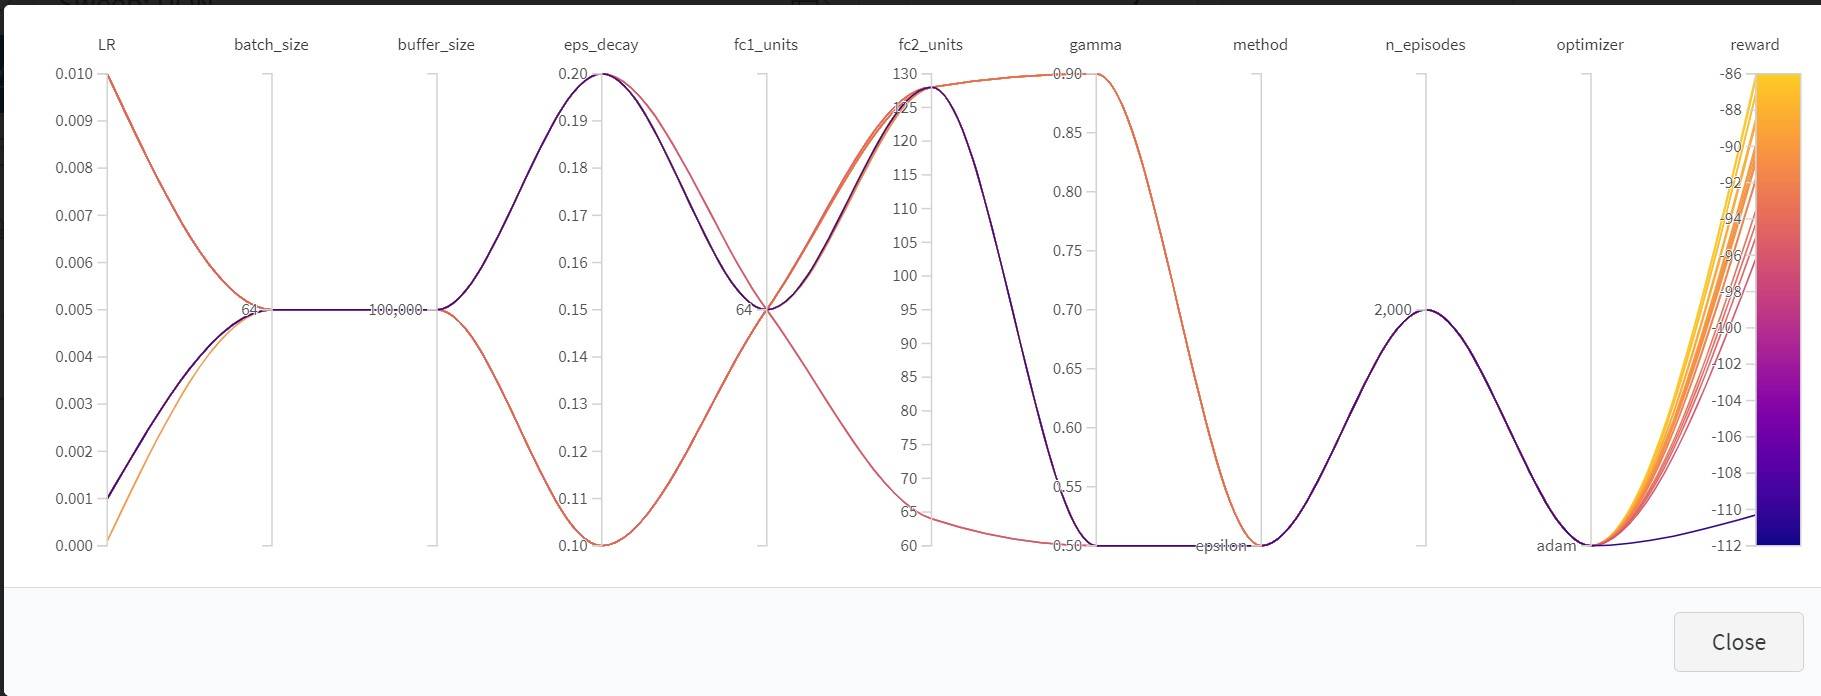

### Acrobot-v1 : Sweep configuration for Softmax

method: bayes
metric:
  goal: maximize
  name: reward
name: DQN
parameters:
  LR:
    values:
    - 0.01
    - 0.001
    - 0.0001
  batch_size:
    values:
    - 64
  buffer_size:
    values:
    - 100000
  fc1_units:
    values:
    - 64
  fc2_units:
    values:
    - 64
    - 128
  gamma:
    values:
    - 0.9
    - 0.5
  method:
    values:
    - softmax
  n_episodes:
    values:
    - 2000
  optimizer:
    values:
    - adam
  temperature:
    values:
    - 0.9
    - 0.001

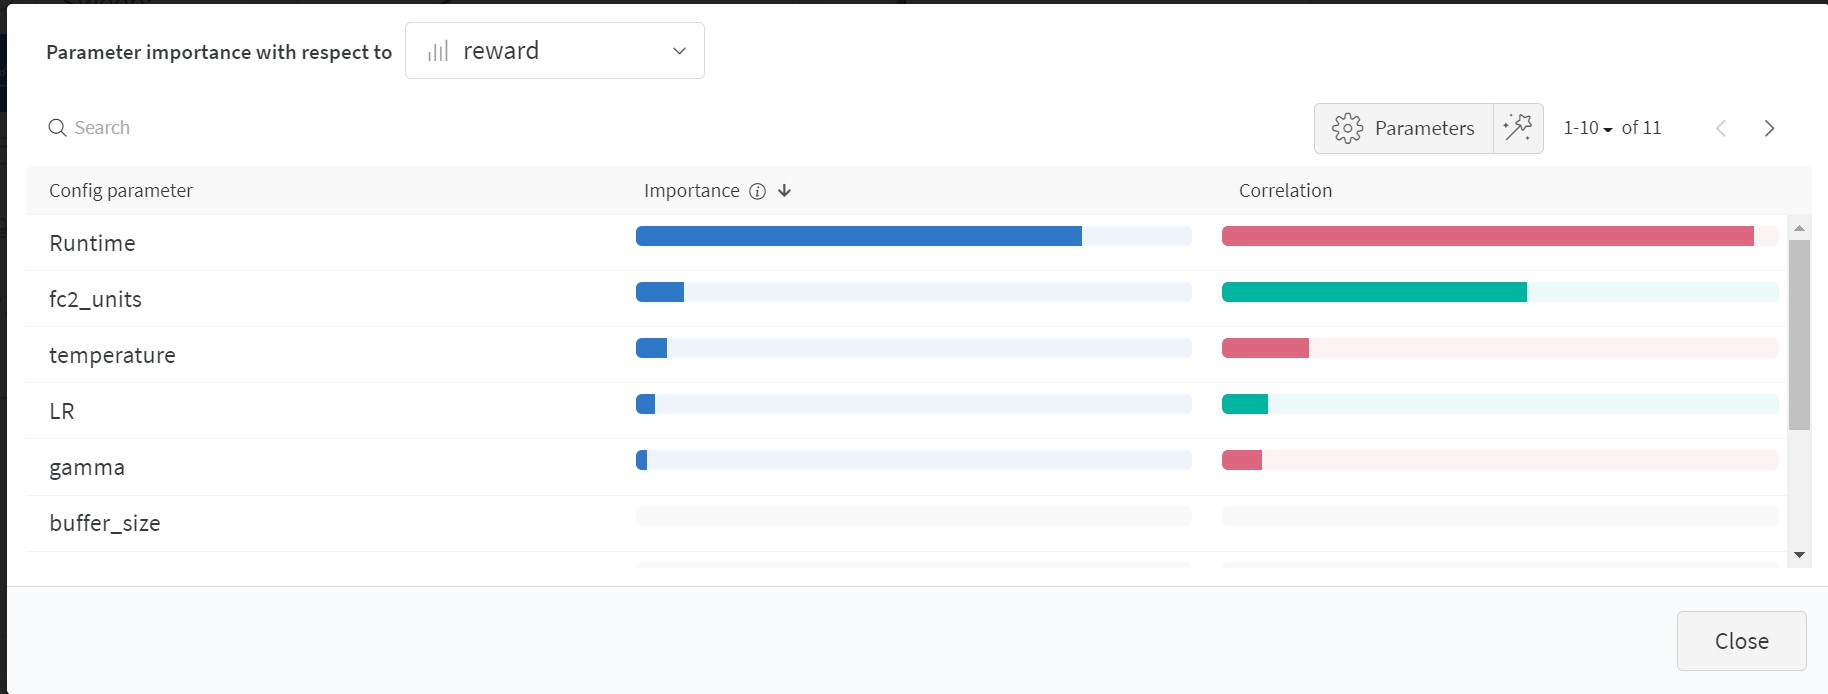

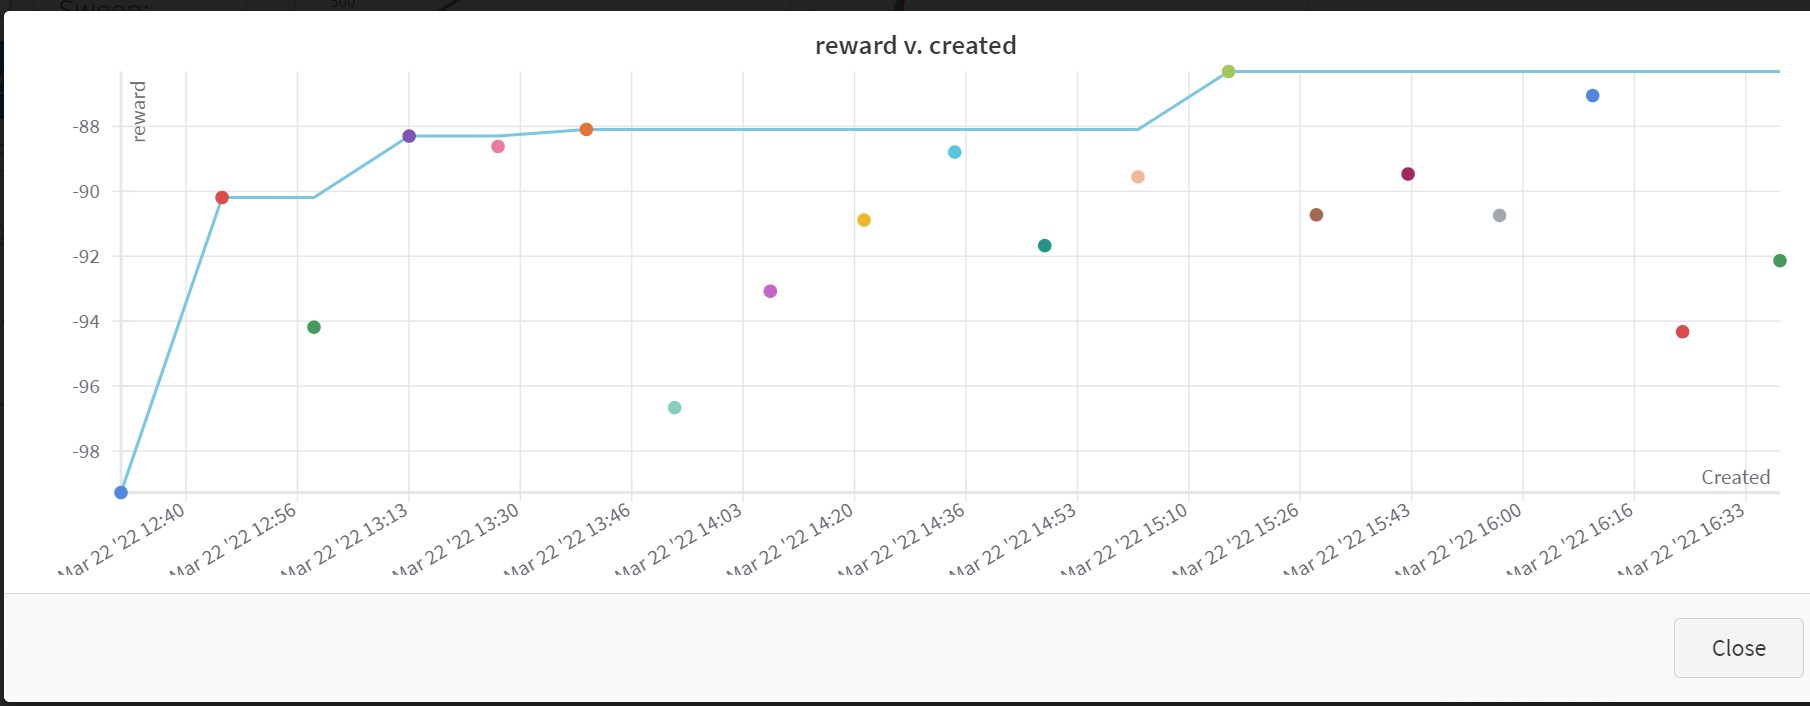

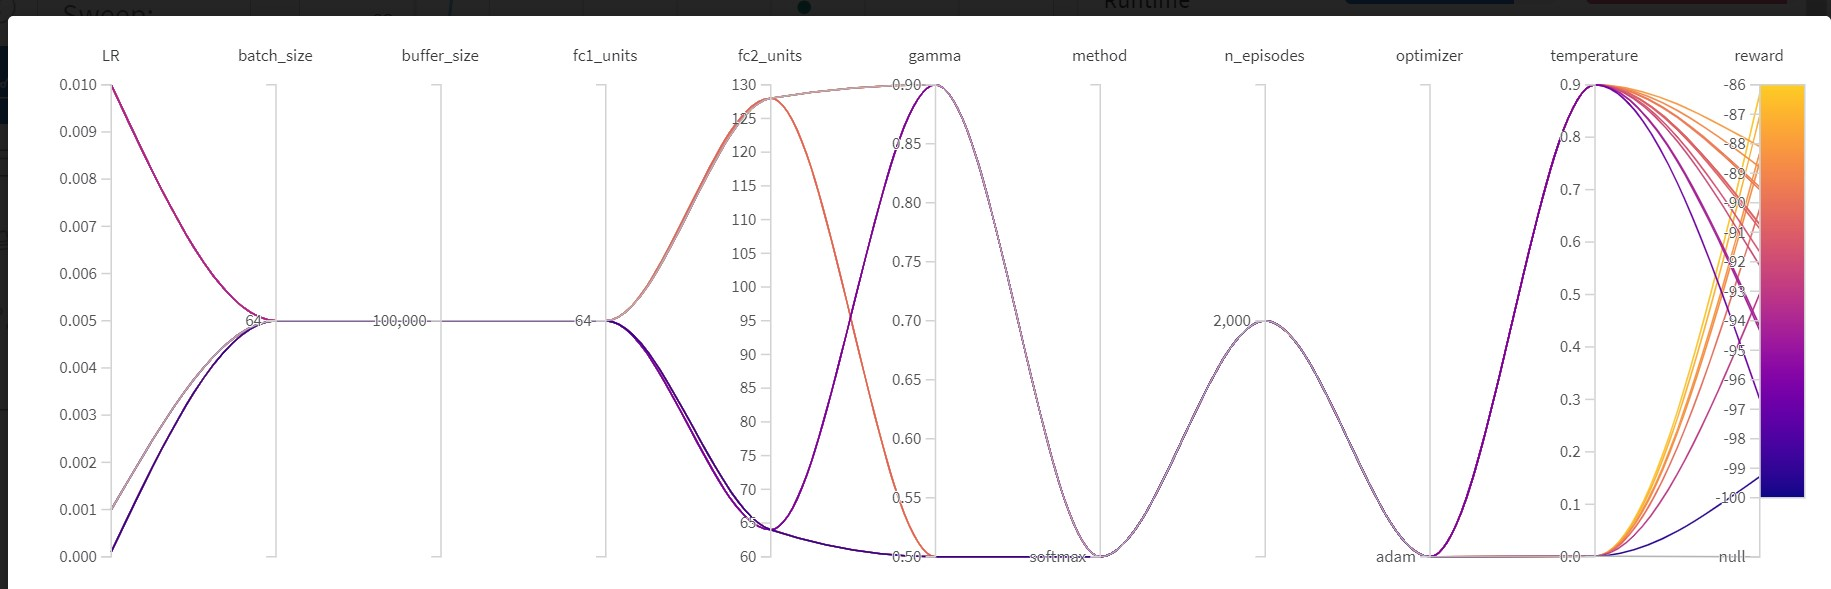

### Epsilon variation

### Configuration 1
* BUFFER_SIZE = int(1e5)
*  BATCH_SIZE =128       
*  GAMMA = 0.99          
* LR = .0001      
*  UPDATE_EVERY = 8      
* method='epsilon'
* eps_decay=0.1
* scoreThreshold=-75
* fc1_units=128
* fc2_units=64
* eps_end=0.001

In [28]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =64         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = .0001#5e-4               #''' learning rate '''
UPDATE_EVERY = 8       #''' how often to update the network (When Q target is present) '''
method='epsilon'
eps_decay=0.1
scoreThreshold=-75
fc1_units=128
fc2_units=64
eps_end=0.001
detailsAcrobotconfig1avg=[]
detailsAcrobotconfig1=[]
stepsconfig1=[]
for i in range(10):
    print('start experiment'+str(i+1))
    env = gym.make('Acrobot  v1')
    env.seed(42)
    state_shape = env.observation_space.shape[0]
    no_of_actions = env.action_space.n
    state = env.reset()   
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_shape,action_size = action_shape,seed = 42,fc1_units=fc1_units,fc2_units= fc2_units,)
    detailsAcrobotEps1avg,detailsAcrobotEps1,steps=dqn(agent=agent,n_episodes=1500,method=method,\
                        buffer_size =BUFFER_SIZE,\
                        batch_size = BATCH_SIZE ,gamma = GAMMA,\
                        LR = LR,update_every = UPDATE_EVERY,\
                        eps_decay=eps_decay,eps_end=eps_end,scoreThreshold=scoreThreshold,isprint=False)#,temperature=0.9)
    time_taken = datetime.datetime.now() - begin_time
    detailsAcrobotconfig1.append(detailsAcrobotEps1)
    detailsAcrobotconfig1avg.append(detailsAcrobotEps1avg)
    stepsconfig1.append(steps)
    print(time_taken)
    print('Complete experiment'+str(i+1))

start experiment1
0:17:03.893804
Complete experiment1
start experiment2
0:15:25.423077
Complete experiment2
start experiment3
0:16:01.972069
Complete experiment3
start experiment4
0:15:57.478309
Complete experiment4
start experiment5
0:15:00.035593
Complete experiment5
start experiment6
0:12:57.730189
Complete experiment6
start experiment7
0:11:59.092999
Complete experiment7
start experiment8
0:12:23.561514
Complete experiment8
start experiment9
0:13:55.277608
Complete experiment9
start experiment10
0:14:57.253721
Complete experiment10


In [29]:
detailsAcrobotconfig1 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig1)]
stepsconfig1=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig1)]
detailsAcrobotconfig1avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig1avg)]

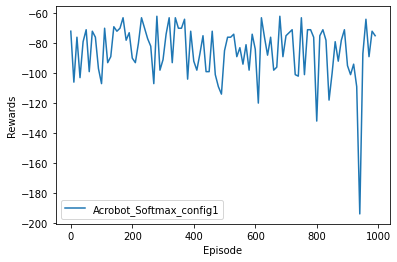

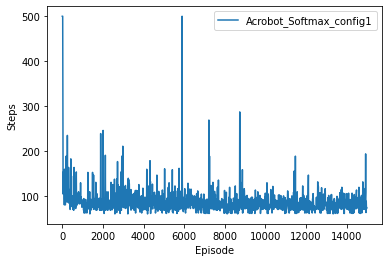

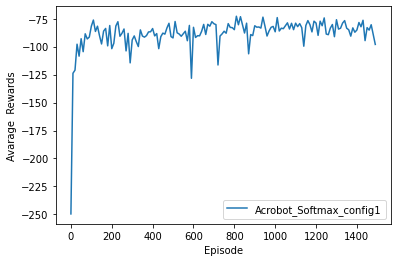

In [30]:

plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig1))*10,detailsAcrobotconfig1,LABEL='Acrobot_Softmax_config1')
plt.legend()
plt.show()



plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig1))*10,stepsconfig1,LABEL='Acrobot_Softmax_config1')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig1avg[0]))*10,detailsAcrobotconfig1avg[0],LABEL='Acrobot_Softmax_config1')

plt.legend()
plt.show()



<font color='red'>It is quite obviousthat after certain steps model is not making good progress.<br>Increasing number of episodes may not be helpful as epsilon value become smaller after certain episodes, as we are decaying the epsilon value.So agent will not explore new states.
<br>In the following configuration we try with more dense network.</font>

### Configuration 2
* BUFFER_SIZE = int(1e5)
* BATCH_SIZE =128       
* GAMMA = 0.999         
* ***LR = .0001***              
* UPDATE_EVERY = 20     
* method='epsilon'
* eps_decay=.1
* scoreThreshold=-75
* ***fc1_units=256***
* ***fc2_units=512***
* eps_end=0.001

In [31]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =128         #''' minibatch size '''
GAMMA = 0.999            #''' discount factor '''
LR = .0001              #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
method='epsilon'
eps_decay=.1
scoreThreshold=-75
fc1_units=256
fc2_units=512
eps_end=0.0001
detailsAcrobotconfig2avg=[]
detailsAcrobotconfig2=[]
stepsconfig2=[]
for i in range(10):
    print('start experiment'+str(i+1))
    env = gym.make('Acrobot-v1')
    env.seed(i)
    state_shape = env.observation_space.shape[0]
    no_of_actions = env.action_space.n
    state = env.reset()   
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_shape,action_size = action_shape,seed = 42,fc1_units=fc1_units,fc2_units= fc2_units,)
    detailsAcrobotEps1avg,detailsAcrobotEps1,steps=dqn(agent=agent,n_episodes=1500,method=method,\
                        buffer_size =BUFFER_SIZE,\
                        batch_size = BATCH_SIZE ,gamma = GAMMA,\
                        LR = LR,update_every = UPDATE_EVERY,\
                        eps_decay=eps_decay,eps_end=eps_end,scoreThreshold=scoreThreshold)#,temperature=0.9)
    time_taken = datetime.datetime.now() - begin_time
    detailsAcrobotconfig2.append(detailsAcrobotEps1)
    detailsAcrobotconfig2avg.append(detailsAcrobotEps1avg)
    stepsconfig2.append(steps)
    print(time_taken)
    print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: -110.06
Episode 200	Average Score: -94.621
Episode 300	Average Score: -88.98
Episode 400	Average Score: -88.58
Episode 500	Average Score: -86.92
Episode 600	Average Score: -81.76
Episode 700	Average Score: -80.08
Episode 800	Average Score: -82.39
Episode 900	Average Score: -80.98
Episode 1000	Average Score: -76.67
Episode 1100	Average Score: -78.29
Episode 1200	Average Score: -75.90
Episode 1259	Average Score: -74.94
Environment solved in 1159 episodes!	Average Score: -74.94
0:16:23.844673
Complete experiment1
start experiment2
Episode 100	Average Score: -110.06
Episode 200	Average Score: -94.621
Episode 300	Average Score: -88.98
Episode 400	Average Score: -88.58
Episode 500	Average Score: -86.92
Episode 600	Average Score: -81.76
Episode 700	Average Score: -80.08
Episode 800	Average Score: -82.39
Episode 900	Average Score: -80.98
Episode 1000	Average Score: -76.67
Episode 1100	Average Score: -78.29
Episode 1200	Average Score: -75.90
Episode 

In [32]:
detailsAcrobotconfig2 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig2)]
stepsconfig2=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig2)]
detailsAcrobotconfig2avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig2avg)]

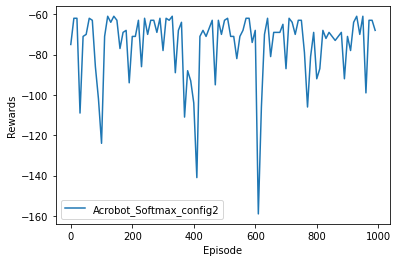

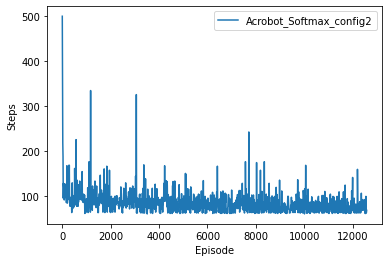

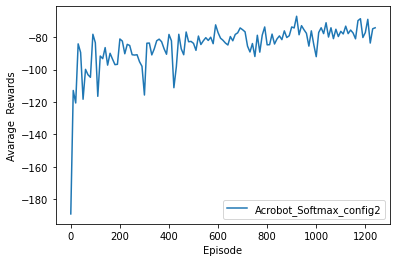

In [33]:

plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig2))*10,detailsAcrobotconfig2,LABEL='Acrobot_Softmax_config2')
plt.legend()
plt.show()



plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig2))*10,stepsconfig2,LABEL='Acrobot_Softmax_config2')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig2avg[0]))*10,detailsAcrobotconfig2avg[0],LABEL='Acrobot_Softmax_config2')

plt.legend()
plt.show()



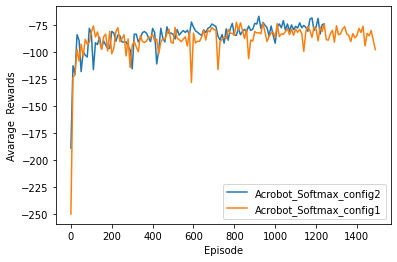

In [34]:
plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig2avg[0]))*10,detailsAcrobotconfig2avg[0],LABEL='Acrobot_Softmax_config2')
plt.plot(np.arange(len(detailsAcrobotconfig1avg[0]))*10,detailsAcrobotconfig1avg[0],LABEL='Acrobot_Softmax_config1')

plt.legend()
plt.show()





***From the above plot is is clearly visible that Config 2 taking less number of steps***<br>
***New we run configuration 3 with larger eps_decay and Learning rate parameter to see if it converge earlier then configuration 2***

### Configuration 3
* BUFFER_SIZE = int(1e5) 
* BATCH_SIZE =64         
* GAMMA = 0.99           
* ***LR = .01***               
* UPDATE_EVERY = 20      
* method='epsilon'
* ***eps_decay=.99***
* eps_end=0.001
* fc1_units=256
* fc2_units=512


In [9]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =64         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = .01               #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
method='epsilon'
eps_decay=.99
eps_end=0.001
fc1_units=256
fc2_units=512
scoreThreshold=-75
detailsAcrobotconfig3avg=[]
detailsAcrobotconfig3=[]
stepsconfig3=[]
detailsAcrobotconfig3=[]
for i in range(10):
    print('start experiment'+str(i+1))
    env = gym.make('Acrobot-v1')
    env.seed(42)
    state_shape = env.observation_space.shape[0]
    no_of_actions = env.action_space.n
    state = env.reset()   
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_shape,action_size = action_shape,seed =42,fc1_units=fc1_units,fc2_units= fc2_units)
    detailsAcrobotEps1avg,detailsAcrobotEps1,steps=dqn(agent=agent,n_episodes=2000,method=method,\
                        buffer_size =BUFFER_SIZE,\
                        batch_size = BATCH_SIZE ,gamma = GAMMA,\
                        LR = LR,update_every = UPDATE_EVERY,eps_end=eps_end,\
                        eps_decay=eps_decay,scoreThreshold=scoreThreshold)#,temperature=0.9)
    time_taken = datetime.datetime.now() - begin_time
    detailsAcrobotconfig3.append(detailsAcrobotEps1)
    detailsAcrobotconfig3avg.append(detailsAcrobotEps1avg)
    stepsconfig3.append(steps)
    print(time_taken)
    print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: -268.85
Episode 200	Average Score: -108.56
Episode 300	Average Score: -88.415
Episode 400	Average Score: -84.85
Episode 500	Average Score: -81.50
Episode 600	Average Score: -81.41
Episode 700	Average Score: -78.83
Episode 800	Average Score: -79.28
Episode 900	Average Score: -75.64
Episode 907	Average Score: -74.95
Environment solved in 807 episodes!	Average Score: -74.95
0:14:46.309129
Complete experiment1
start experiment2
Episode 100	Average Score: -268.85
Episode 200	Average Score: -108.56
Episode 300	Average Score: -88.415
Episode 400	Average Score: -84.85
Episode 500	Average Score: -81.50
Episode 600	Average Score: -81.41
Episode 700	Average Score: -78.83
Episode 800	Average Score: -79.28
Episode 900	Average Score: -75.64
Episode 907	Average Score: -74.95
Environment solved in 807 episodes!	Average Score: -74.95
0:13:37.146352
Complete experiment2
start experiment3
Episode 100	Average Score: -268.85
Episode 200	Average Score: -108.56
Ep

In [10]:
detailsAcrobotconfig3 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig3)]
stepsconfig3=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig3)]
detailsAcrobotconfig3avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig3avg)]

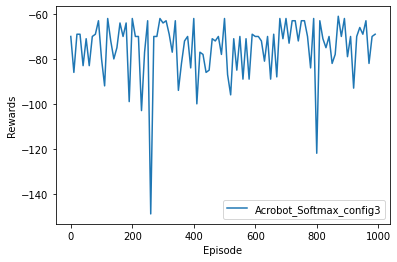

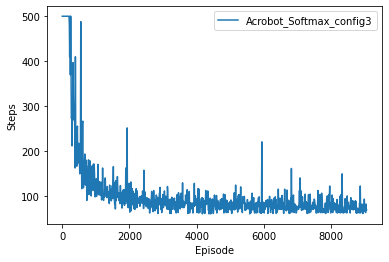

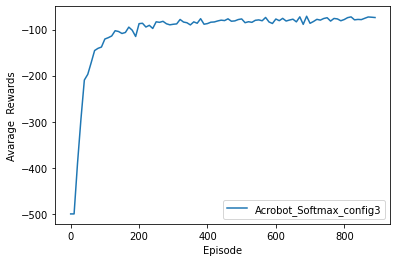

In [11]:

plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig3))*10,detailsAcrobotconfig3,LABEL='Acrobot_Softmax_config3')
plt.legend()
plt.show()



plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig3))*10,stepsconfig3,LABEL='Acrobot_Softmax_config3')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig3avg[0]))*10,detailsAcrobotconfig3avg[0],LABEL='Acrobot_Softmax_config3')

plt.legend()
plt.show()



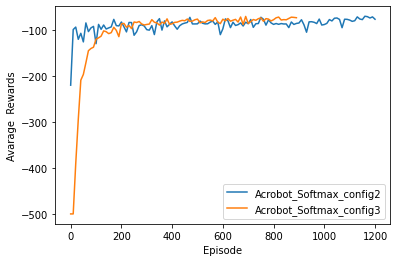

In [14]:
plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig2avg[0]))*10,detailsAcrobotconfig2avg[0],LABEL='Acrobot_Softmax_config2')
plt.plot(np.arange(len(detailsAcrobotconfig3avg[0]))*10,detailsAcrobotconfig3avg[0],LABEL='Acrobot_Softmax_config3')

plt.legend()
plt.show()





***Clearly cofiguration 3 converge little earlier than config 2***

### Softmax variation

*** We will use softmax function instead of epsilon gready and try with different Temperature(T) value. As We higher the T, the 'softer' the distribution will become as  the model will  be less confident about it's prediction. And when  T gets closer to 0, the 'harder' the distribution gets and  model become  extremely confident. ***

 ## Configuration 4


*   method : Sofrtmax
*   temperature : 0.9
*   scoreThreshold : -75
* n_episodes: 1000
* fc1_units : 64
* fc2_units : 128
* optimizer : 'adam'



In [15]:

BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE = 64        #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = .0001              #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
scoreThreshold=-75
temperature=0.9
n_episodes=1000
fc1_units=64
fc2_units=128
method='softmax'


detailsAcrobotconfig4avg=[]
detailsAcrobotconfig4=[]
stepsconfig4=[]
for i in range(10):
    print('start experiment'+str(i+1))
    env = gym.make('Acrobot-v1')
    env.seed(42)
    state_shape = env.observation_space.shape[0]
    no_of_actions = env.action_space.n
    state = env.reset()   
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_shape,action_size = action_shape,seed = 42,\
                  fc1_units= fc2_units, fc2_units= fc2_units,optimizer= 'adam')
    detailsAcrobotEps1avg,detailsAcrobotEps1,steps=dqn(agent=agent,n_episodes=n_episodes,method=method,\
                        buffer_size = BUFFER_SIZE ,\
                        batch_size =BATCH_SIZE,gamma = GAMMA,\
                        LR =  LR,update_every = UPDATE_EVERY,\
                        scoreThreshold=scoreThreshold,temperature=temperature)   
    time_taken = datetime.datetime.now() - begin_time
    detailsAcrobotconfig4.append(detailsAcrobotEps1)
    detailsAcrobotconfig4avg.append(detailsAcrobotEps1avg)
    stepsconfig4.append(steps)
    print(time_taken)

start experiment1
Episode 100	Average Score: -162.24
Episode 200	Average Score: -151.59
Episode 300	Average Score: -151.91
Episode 400	Average Score: -150.98
Episode 500	Average Score: -156.01
Episode 600	Average Score: -148.16
Episode 700	Average Score: -148.62
Episode 800	Average Score: -143.62
Episode 900	Average Score: -145.09
Episode 1000	Average Score: -139.73
0:18:34.765164
start experiment2
Episode 100	Average Score: -182.03
Episode 200	Average Score: -158.29
Episode 300	Average Score: -157.43
Episode 400	Average Score: -158.70
Episode 500	Average Score: -153.63
Episode 600	Average Score: -146.94
Episode 700	Average Score: -148.69
Episode 800	Average Score: -150.87
Episode 900	Average Score: -146.23
Episode 1000	Average Score: -148.27
0:20:50.394494
start experiment3
Episode 100	Average Score: -182.64
Episode 200	Average Score: -149.88
Episode 300	Average Score: -150.49
Episode 400	Average Score: -152.47
Episode 500	Average Score: -150.61
Episode 600	Average Score: -148.52
Epis

In [16]:
detailsAcrobotconfig4 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig4)]
stepsconfig4=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig4)]
detailsAcrobotconfig4avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig4avg)]

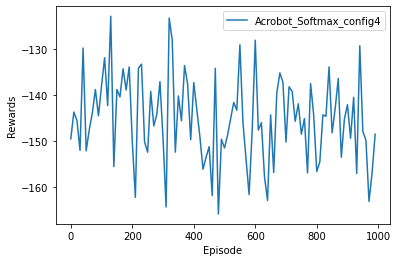

In [17]:
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig4))*10,detailsAcrobotconfig4,LABEL='Acrobot_Softmax_config4')

plt.legend()
plt.show()





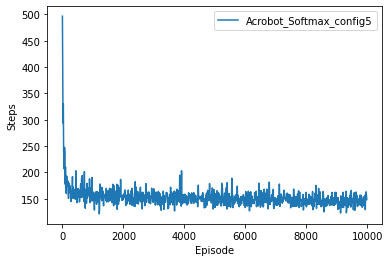

In [18]:
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig4))*10,stepsconfig4,LABEL='Acrobot_Softmax_config5')

plt.legend()
plt.show()





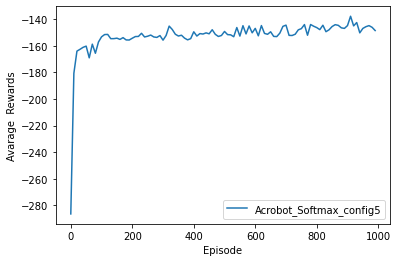

In [19]:
plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig4avg[0]))*10,detailsAcrobotconfig4avg[0],LABEL='Acrobot_Softmax_config5')

plt.legend()
plt.show()





## configuration 5


*   method : Sofrtmax
*   ***temperature : 0.0001***
*   scoreThreshold : -75
* n_episodes: 1000
* fc1_units : 64
* fc2_units : 128
* optimizer : 'adam'

In [20]:

BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE = 64        #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = .0001              #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
scoreThreshold=-75
temperature=0.0001
n_episodes=1000
fc1_units=64
fc2_units=128
method='softmax'


detailsAcrobotconfig5avg=[]
detailsAcrobotconfig5=[]
stepsconfig5=[]
for i in range(10):
    print('start experiment'+str(i+1))
    env = gym.make('Acrobot-v1')
    env.seed(42)
    state_shape = env.observation_space.shape[0]
    no_of_actions = env.action_space.n
    state = env.reset()   
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_shape,action_size = action_shape,seed = 42,\
                  fc1_units= fc2_units, fc2_units= fc2_units,optimizer= 'adam')
    detailsAcrobotEps1avg,detailsAcrobotEps1,steps=dqn(agent=agent,n_episodes=n_episodes,method=method,\
                        buffer_size = BUFFER_SIZE ,\
                        batch_size =BATCH_SIZE,gamma = GAMMA,\
                        LR =  LR,update_every = UPDATE_EVERY,\
                        scoreThreshold=scoreThreshold,temperature=temperature)   
    time_taken = datetime.datetime.now() - begin_time
    detailsAcrobotconfig5.append(detailsAcrobotEps1)
    detailsAcrobotconfig5avg.append(detailsAcrobotEps1avg)
    stepsconfig5.append(steps)
    print(time_taken)

start experiment1
Episode 100	Average Score: -125.45
Episode 200	Average Score: -94.907
Episode 300	Average Score: -105.34
Episode 400	Average Score: -94.885
Episode 500	Average Score: -92.342
Episode 600	Average Score: -90.33
Episode 700	Average Score: -86.39
Episode 800	Average Score: -94.67
Episode 900	Average Score: -91.48
Episode 1000	Average Score: -91.64
0:14:03.904530
start experiment2
Episode 100	Average Score: -124.03
Episode 200	Average Score: -89.005
Episode 300	Average Score: -105.43
Episode 400	Average Score: -95.162
Episode 500	Average Score: -92.78
Episode 600	Average Score: -88.72
Episode 700	Average Score: -87.20
Episode 800	Average Score: -87.97
Episode 900	Average Score: -91.19
Episode 1000	Average Score: -87.26
0:13:57.430199
start experiment3
Episode 100	Average Score: -128.92
Episode 200	Average Score: -105.82
Episode 300	Average Score: -95.228
Episode 400	Average Score: -104.34
Episode 500	Average Score: -92.211
Episode 600	Average Score: -88.77
Episode 700	Aver

In [21]:
detailsAcrobotconfig5 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig5)]
stepsconfig5=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig5)]
detailsAcrobotconfig5avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig5avg)]

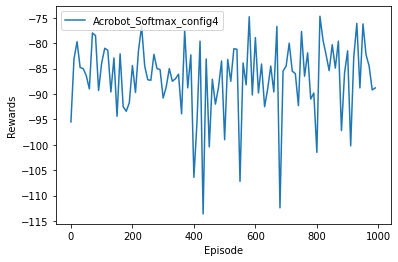

In [22]:
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig5))*10,detailsAcrobotconfig5,LABEL='Acrobot_Softmax_config4')

plt.legend()
plt.show()





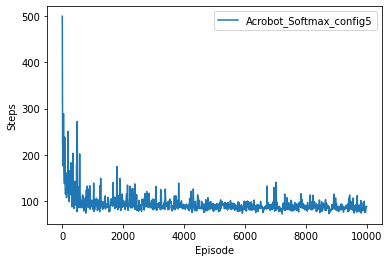

In [23]:

plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig5))*10,stepsconfig5,LABEL='Acrobot_Softmax_config5')

plt.legend()
plt.show()





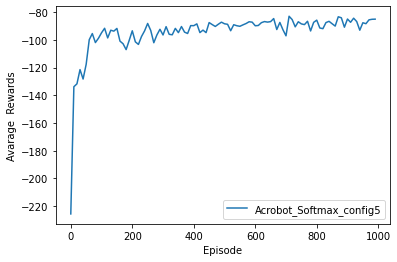

In [24]:

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig5avg[0]))*10,detailsAcrobotconfig5avg[0],LABEL='Acrobot_Softmax_config5')

plt.legend()
plt.show()





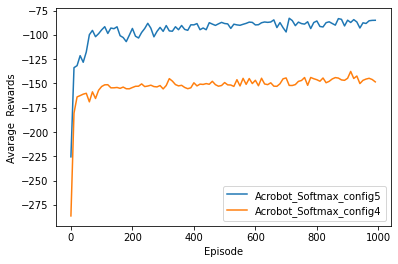

In [25]:
plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig5avg[0]))*10,detailsAcrobotconfig5avg[0],LABEL='Acrobot_Softmax_config5')
plt.plot(np.arange(len(detailsAcrobotconfig4avg[0]))*10,detailsAcrobotconfig4avg[0],LABEL='Acrobot_Softmax_config4')

plt.legend()
plt.show()





 <font color='red'>So after the abobe two experiment on configuration 4 and configuration 5 , we can conclude model gives good reward when when choose low temparature (closure to zero)and make model more confident</font><br><br>***Now use same configuration but with an dense network in configuration 6***

## configuration 6


*   method : Sofrtmax
*   ***temperature : 0.0001***
*   scoreThreshold : -75
* n_episodes: 1500
* ***fc1_units : 256***
* ***fc2_units : 512***
* optimizer : 'adam'

In [30]:

BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE = 64        #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = .0001              #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''
scoreThreshold=-50
temperature=0.0001
n_episodes=1000
fc1_units=256
fc2_units=512
method='softmax'


detailsAcrobotconfig6avg=[]
detailsAcrobotconfig6=[]
stepsconfig6=[]
for i in range(10):
    print('start experiment'+str(i+1))
    env = gym.make('Acrobot-v1')
    env.seed(42)
    state_shape = env.observation_space.shape[0]
    no_of_actions = env.action_space.n
    state = env.reset()   
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_shape,action_size = action_shape,seed = 42,\
                  fc1_units= fc2_units, fc2_units= fc2_units,optimizer= 'adam')
    detailsAcrobotEps1avg,detailsAcrobotEps1,steps=dqn(agent=agent,n_episodes=n_episodes,method=method,\
                        buffer_size = BUFFER_SIZE ,\
                        batch_size =BATCH_SIZE,gamma = GAMMA,\
                        LR =  LR,update_every = UPDATE_EVERY,\
                        scoreThreshold=scoreThreshold,temperature=temperature)   
    time_taken = datetime.datetime.now() - begin_time
    detailsAcrobotconfig6.append(detailsAcrobotEps1)
    detailsAcrobotconfig6avg.append(detailsAcrobotEps1avg)
    stepsconfig6.append(steps)
    print(time_taken)

start experiment1
Episode 100	Average Score: -118.75
Episode 200	Average Score: -94.408
Episode 300	Average Score: -94.44
Episode 400	Average Score: -84.49
Episode 500	Average Score: -84.50
Episode 600	Average Score: -83.55
Episode 700	Average Score: -78.58
Episode 800	Average Score: -82.04
Episode 900	Average Score: -80.26
Episode 1000	Average Score: -87.00
0:13:15.242665
start experiment2
Episode 100	Average Score: -113.44
Episode 200	Average Score: -92.372
Episode 300	Average Score: -90.38
Episode 400	Average Score: -88.74
Episode 500	Average Score: -84.37
Episode 600	Average Score: -80.17
Episode 700	Average Score: -82.31
Episode 800	Average Score: -78.81
Episode 900	Average Score: -74.66
Episode 1000	Average Score: -74.38
0:11:30.270724
start experiment3
Episode 100	Average Score: -113.62
Episode 200	Average Score: -91.472
Episode 300	Average Score: -89.20
Episode 400	Average Score: -80.97
Episode 500	Average Score: -83.32
Episode 600	Average Score: -78.59
Episode 700	Average Scor

In [31]:
detailsAcrobotconfig6 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig6)]
stepsconfig6=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig6)]
detailsAcrobotconfig6avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsAcrobotconfig6avg)]

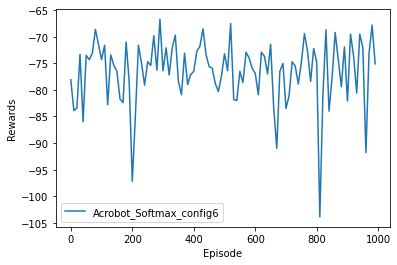

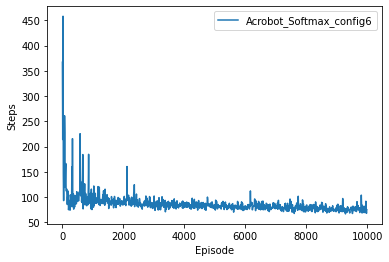

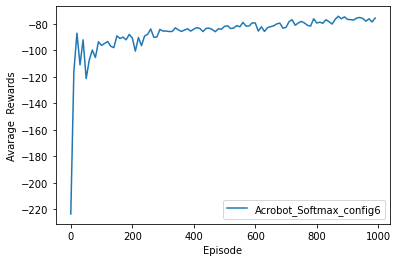

In [32]:
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig6))*10,detailsAcrobotconfig6,LABEL='Acrobot_Softmax_config6')

plt.legend()
plt.show()



plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig6))*10,stepsconfig6,LABEL='Acrobot_Softmax_config6')

plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig6avg[0]))*10,detailsAcrobotconfig6avg[0],LABEL='Acrobot_Softmax_config6')

plt.legend()
plt.show()





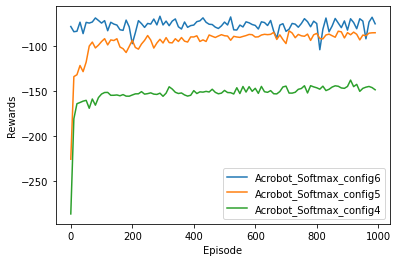

In [33]:
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(np.arange(len(detailsAcrobotconfig6))*10,detailsAcrobotconfig6,LABEL='Acrobot_Softmax_config6')
plt.plot(np.arange(len(detailsAcrobotconfig5avg[0]))*10,detailsAcrobotconfig5avg[0],LABEL='Acrobot_Softmax_config5')
plt.plot(np.arange(len(detailsAcrobotconfig4avg[0]))*10,detailsAcrobotconfig4avg[0],LABEL='Acrobot_Softmax_config4')

plt
plt.legend()
plt.show()



***configuration 6 performing better***